# Segmentation of fluid on OCT

Presence of fluid, as visualised by optical coherence tomography (OCT) is an important indication for treatment for several retinal diseases. Manual segmentation is subjective, tedious and time-consuming. Therefore, we whish to automate this process.

## Dataset


In the folder `sample`, you will find three subfolders: `oct`, `irf`  and `srf`

The folder `oct` contains grayscale OCT images. The irf and srf folder contain manually segmentation masks for intraretinal fluid and subretinal fluid respectively.
OCT images can be linked to their respective segmentation masks based on their filenames.

## Tasks

You task is to implement a segmentation model that takes as input and OCT-scan and produces binary segmentation masks representing IRF and SRF.  
We do not expect you to deliver a perfectly trained model, but do like to know your thoughts on particular implementation details that may require particular attention in this pipeline.

If you can implement parts of the pipeline that is great, otherwise please specify what functionality (input and expected output) is required at each step in pseudocode.


### 1) Data loading and preprocessing

Load the images into memory and prepare them for training the model.

- What input size do you use?

-- The dimension of the provided oct, irf, and srf images are 512 X 885, and 512 X 496. I plan to use UNet architecture to model development and there is a limit of input size has to be 572 X 572, therefore we cannot use input size 512 X 885. So, I plan to use input size 512 X 496. There is a trade-off- if we use bigger input size, the model will achieve better performance but with a reduced speed.


- How would you normalize the data?

--  First, I find the pixel value statistics (max, min, mean, std) of the images. I plan to do three pixel normalization such as 
a) Pixel Normalization: scale pixel values to the range 0-1.
b) Pixel Centering: scale pixel values to have a zero mean.
c) Pixel Standardization: scale pixel values to have a zero mean and unit variance.

- Which image transformations do you apply?

-- There is only 167 images provided which seems smaller in number required to build deep learning model. Therefore, there is need for image augmentation to increase data size and also to develop a generalized model. I have implemented following transformation of the images-

1)	Vertical flip
2)	Horizontal flip
3)	Random rotation
4)	Transpose
5)	Grid distortion
6)	Elastic transform

### Install necessary pacakges and Load images for training 

In [ ]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

In [29]:
%matplotlib inline

In [30]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [31]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
!unzip data.zip

In [41]:
#Resize images (height  = X, width = Y)
SIZE_X = 512 
SIZE_Y = 496

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/data/oct"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        
     
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/data/irf"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
                 
train_masks = np.array(train_masks)


### Image Transormation 

-- There is only 167 images provided which seems smaller in number required to build deep learning model. Therefore, there is need for image augmentation to increase data size and also to have a generalized model. I have implemented following transformation of the images to generate 1000 new images from the original 165 oct images.

1) Vertical flip 2) Horizontal flip 3) Random rotation 4) Transpose 5) Grid distortion 6) Elastic transform

In [ ]:
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
from scipy.ndimage import rotate

import albumentations as A
images_to_generate=1000




images_path="/content/data/oct/" #path to original images
masks_path = "/content/data/irf/"
img_augmented_path="/content/data/aug_img/" # path to store aumented images
msk_augmented_path="/content/data/aug_mask/" # path to store aumented images
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))


aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    #A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=1)
    ]
)

#random.seed(42)

i=1   # variable to iterate till images_to_generate


while i<=images_to_generate: 
    number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
    image = images[number]
    mask = masks[number]
    print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    
    augmented = aug(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']

        
    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

In [43]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)  

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


### 2) Model definition and initialization 

Define a model that is able to take in an OCT-scan and produces two segmentation images: one representing IRF, and one representing SRF.

- What network architecture do you use? 

-- I have used U-Net architecture for developing oct image segmentation. The U-Net is convolutional network used for fast and precise segmentation of images. Recently, it has outperformed the prior best method on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories by a large margin. It seems U-Net is very efficient for medical image segmentaation. Therefore, I decided to adapt the U-Net architecture for oct image segmentation. 

- Specify the exact input and output shapes and datatypes of the model

-- The input is a grayscale oct image (shape= nX512X496Xch) and output is a binary segmented image (shape nX512X496X1). here, n is the number of images, ch is the channel numbers. 


### 3) Training, validation and experimentation 

How would you set up you experiments?

-- First, I randomly split the provide images into training (80%) and testing (20%). As there are very limited number of images, so I will use pre-trained ImageNet weights rather than training from scratch. I selected resnet34 architecture as backbone, a batch size of 32, epochs 2000. Although, I generated 1000 new oct images through image augmentation, I have used only provided 167 original images while developing the model as it will take long time to build the model with all the 1167 images.

- What loss function do you use?

-- Jaccard loss function has been used. We can use other loss function such as cross-entrophy. We used Jaccard for only demonstration purpose.

- Which validation metrics are useful here?

-- Intersection over union(IoU) metric has been used as evaluation metric. We can use other evaluation metrics such as accuracy, mean square error (MSE). Here IoU will be useful as compared to other metric as we want optimize the detection and localization of irf and srf. Accuracy is not useful for limited unvalnced data. 

- Which (hyper)parameters should be tuned?

-- Different hyperparameters such as Batch size, training step and epoch, number of filters, optimizer, pooling, and stride size can be tuned while developing segmentation model. In our case, I have used pre-trained UNet model with imagenet weights, so most of this parameters used as unchanged from default setup. In future, to have an optimize model we should tune most of these parameters.


In [44]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_409 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_409[0][0]         
___________________________________________________________________________________________

In [ ]:
# fit model
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=2000,
   verbose=1,
   validation_data=(x_val, y_val),
)

In [48]:
accuracy = model.evaluate(x_val, y_val)
print(accuracy[1])

34/34 [==============================] - 0s 3ms/step
2.103879928588867


### Save Model

In [ ]:
model.save('/content/model/oct_segment_model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/model/oct_segment_model.h5', compile=False)

### Test and Visulize Model Performance

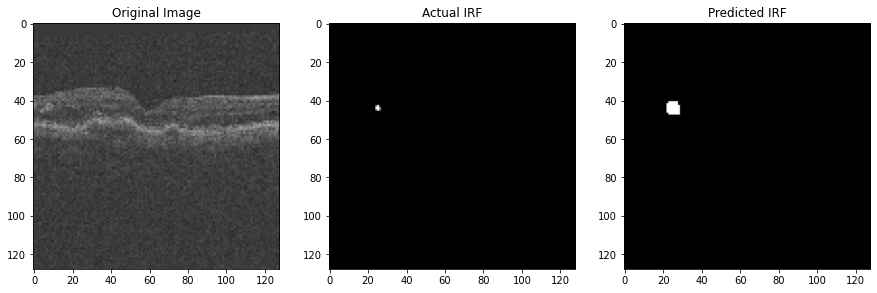

In [57]:

#Test on a IRF image

test_img = cv2.imread('/content/data/oct/133.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

test_mask = cv2.imread('/content/data/irf/133.png', cv2.IMREAD_COLOR)       
test_mask = cv2.resize(test_mask, (SIZE_Y, SIZE_X))
test_mask = cv2.cvtColor(test_mask, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Actual IRF')
plt.imshow(test_mask, cmap='gray')

test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
prediction_image = prediction.reshape(mask.shape)
plt.subplot(1, 3, 3)
plt.title('Predicted IRF')
plt.imshow(prediction_image, cmap='gray')

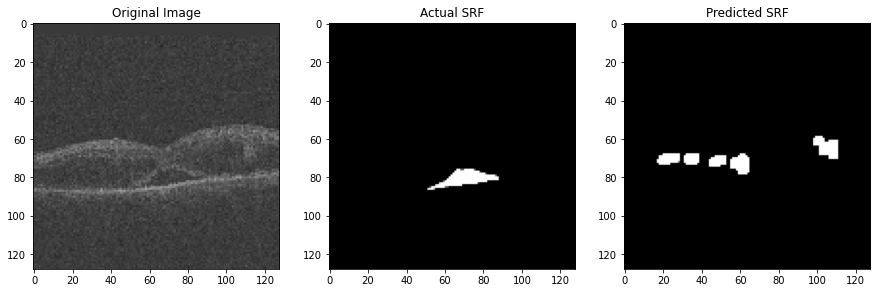

In [60]:
#Test on a SRF image

test_img = cv2.imread('/content/data/oct/23.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

test_mask = cv2.imread('/content/data/srf/23.png', cv2.IMREAD_COLOR)       
test_mask = cv2.resize(test_mask, (SIZE_Y, SIZE_X))
test_mask = cv2.cvtColor(test_mask, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(test_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Actual SRF')
plt.imshow(test_mask, cmap='gray')

test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)
prediction_image = prediction.reshape(mask.shape)
plt.subplot(1, 3, 3)
plt.title('Predicted SRF')
plt.imshow(prediction_image, cmap='gray')

### Remarks

1) The model performing well in finding IRF mask from the test oct data as shown above.

2) However, we observe that the predicted SRF mask is way off from the actual SRF mask. The reason for that is the model has been training with oct images and IRF mask and tested on oct images with SRF mask. The idea was to see how model performs on unseen data.   

3) I need some more time to optimize the model, train with more data if availablre, use both irf and srf masks during training to have an efficient model that can detect both IRF and SRF mask from oct images. 

### Acknowledgement

I have adapted this GitHub repo- (https://github.com/bnsreenu/python_for_microscopists/blob/master/177_semantic_segmentation_made_easy_using_segm_models.py) to develop a customized segmentation model for our oct dataset. 